In [1]:
import model
import utils
import jax.numpy as jnp
import jax
import einops
import optax

import matplotlib.pyplot as plt
import ipdb
import tqdm.notebook as tqdm
import pprint

## Generate 2 tasks 

In [126]:
sampling_rate = 0.1
duration = 10
T = int(duration/sampling_rate)


def generate_data(D, freqs, sampling_rate, duration, noise=False):
    time_bins = jnp.arange(0, duration, sampling_rate)
    omega_t = einops.rearrange(time_bins, 't->t ()') * freqs
    data = jnp.cos(omega_t)
    if noise:
        data += jax.random.normal(jax.random.PRNGKey(42), data.shape) * 0.02

    x_init = jax.random.uniform(jax.random.PRNGKey(42), (int(duration/sampling_rate),len(freqs),D),
                                        minval=0,
                                        maxval=1)
    return data, x_init

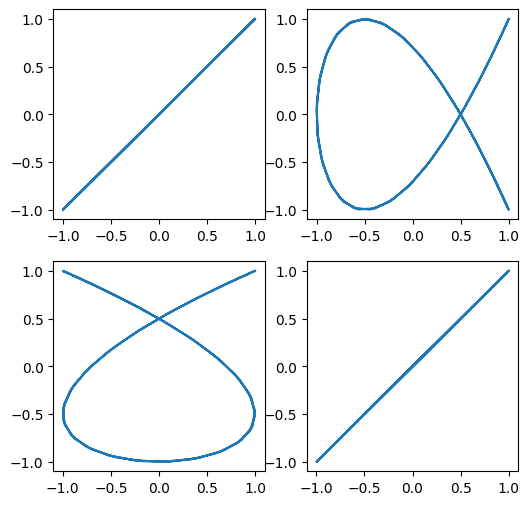

In [127]:
D = 6
angular_freqs = jnp.array([2,3])
teacher_y, x_init =generate_data(D,angular_freqs, sampling_rate, duration)
d = teacher_y.shape[1]
fig, axes = plt.subplots(d, d, figsize=(6, 6))
for i in range(d):
    for j in range(d):
        ax = axes[i, j]
        ax.plot(teacher_y[:, i], teacher_y[:, j])
        #ax.plot(teacher_y[:, i] + teacher_y[:, j])

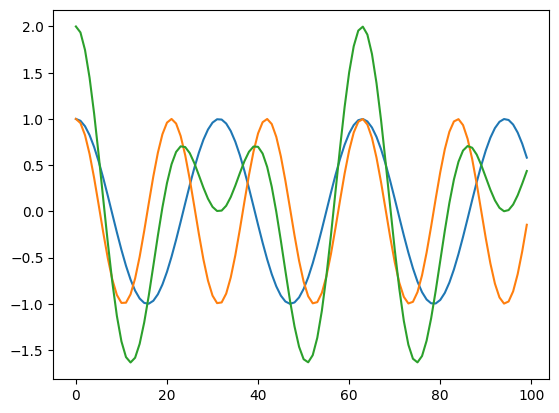

In [142]:
plt.plot(teacher_y[:, 0])
plt.plot(teacher_y[:, 1])
plt.plot(np.sum(teacher_y, axis=1))

## Train 2 teacher modules

In [128]:
key = jax.random.PRNGKey(42)
K = len(angular_freqs)

collocation_teachers = [model.CollocationModel(K= 1, D = D, T=T, x = x_init[:,i].squeeze(), lambdas = model.LAMBDAS, key =key) for i in range(K)]
collocation_auxs = [None, None]
for i, collocation_teacher in enumerate(collocation_teachers):
    print(f'Train teacher{i} for frequency {angular_freqs[i]}')
    optimizer = optax.adam(1e-3)
    optimizer_state = optimizer.init(collocation_teacher)
    for _ in tqdm.trange(int(2e4)):
        key, subkey = jax.random.split(key)
        collocation_teacher, optimizer_state, collocation_aux = model.train_step(
            collocation_teacher,
            optimizer_state,
            optimizer,
            teacher_y[:, i][:, None],
            key=subkey)
        collocation_teachers[i] = collocation_teacher
        collocation_auxs[i] = collocation_aux
        if _ % 5e3 == 0:
            pprint.pprint(collocation_aux['losses'])



Train teacher0 for frequency 2


  0%|          | 0/20000 [00:00<?, ?it/s]

{'activation_energy': Array(0.3391498, dtype=float32),
 'activation_positivity': Array(0., dtype=float32),
 'readout_energy': Array(0.12120156, dtype=float32),
 'target': Array(0.48495746, dtype=float32),
 'transition': Array(0.07176352, dtype=float32),
 'transition_energy': Array(0.04674931, dtype=float32)}
{'activation_energy': Array(0.25247005, dtype=float32),
 'activation_positivity': Array(6.375098e-05, dtype=float32),
 'readout_energy': Array(0.19386639, dtype=float32),
 'target': Array(1.0601085e-06, dtype=float32),
 'transition': Array(8.2516317e-07, dtype=float32),
 'transition_energy': Array(0.07768718, dtype=float32)}
{'activation_energy': Array(0.19925556, dtype=float32),
 'activation_positivity': Array(8.4959596e-05, dtype=float32),
 'readout_energy': Array(0.17968002, dtype=float32),
 'target': Array(3.234818e-07, dtype=float32),
 'transition': Array(1.5695717e-06, dtype=float32),
 'transition_energy': Array(0.06485952, dtype=float32)}
{'activation_energy': Array(0.182906

  0%|          | 0/20000 [00:00<?, ?it/s]

{'activation_energy': Array(0.3140887, dtype=float32),
 'activation_positivity': Array(0., dtype=float32),
 'readout_energy': Array(0.12402163, dtype=float32),
 'target': Array(0.44207826, dtype=float32),
 'transition': Array(0.08135159, dtype=float32),
 'transition_energy': Array(0.03944485, dtype=float32)}
{'activation_energy': Array(0.24041502, dtype=float32),
 'activation_positivity': Array(5.381809e-05, dtype=float32),
 'readout_energy': Array(0.19796078, dtype=float32),
 'target': Array(8.633638e-07, dtype=float32),
 'transition': Array(7.4361683e-06, dtype=float32),
 'transition_energy': Array(0.1583952, dtype=float32)}
{'activation_energy': Array(0.19388874, dtype=float32),
 'activation_positivity': Array(9.6022064e-05, dtype=float32),
 'readout_energy': Array(0.18743664, dtype=float32),
 'target': Array(1.3160295e-06, dtype=float32),
 'transition': Array(8.262624e-07, dtype=float32),
 'transition_energy': Array(0.06945405, dtype=float32)}
{'activation_energy': Array(0.18204948

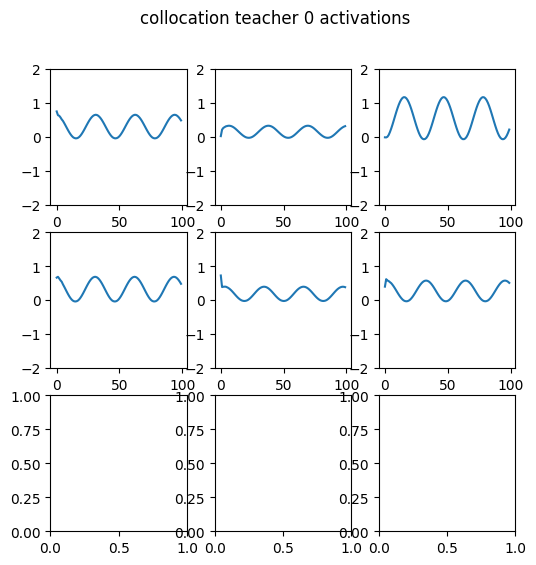

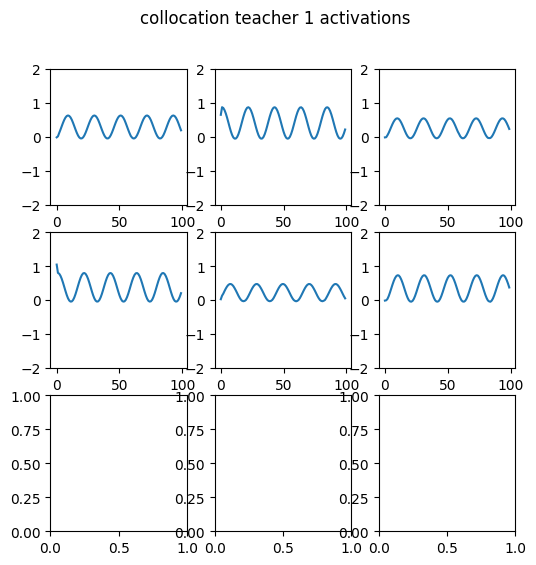

In [129]:
for k in range(K):
    fig, axes = plt.subplots(int(jnp.ceil(jnp.sqrt(D))), int(jnp.ceil(jnp.sqrt(D))), figsize=(6, 6))
    for i in range(D):
        ax = axes[i // int(jnp.ceil(jnp.sqrt(D))), i%int(jnp.ceil(jnp.sqrt(D)))]
        ax.plot(collocation_teachers[k].x[:, i])
        ax.set_ylim(-2, 2)
    fig.suptitle(f'collocation teacher {k} activations')

## Make it better with shooting model training

In [130]:
shooting_teachers = [
    model.ShootingModel(T=T, D= D, K =1, lambdas = model.SHOOTING_LAMBDAS,
                            x0=collocation_teachers[i].x[0, :],
                            W=collocation_auxs[i]['W'][:-1, :],
                            R=collocation_auxs[i]['R'][:-1, :],
                            bw=collocation_auxs[i]['W'][-1, :],
                            br=collocation_auxs[i]['R'][-1, :],
                            key=key) for i in range(K)
]
shooting_teacher_auxs = [None, None]
for i, shooting_teacher in enumerate(shooting_teachers):
    print(f'Train teacher{i} for frequency {angular_freqs[i]} with shooting model')
    optimizer = optax.adam(1e-3)
    optimizer_state = optimizer.init(shooting_teacher)
    for _ in tqdm.trange(int(1e4)):
        key, subkey = jax.random.split(key)
        shooting_teacher, optimizer_state, aux = model.train_step(
            shooting_teacher,
            optimizer_state,
            optimizer,
            teacher_y[:, i][:,None],
            key=subkey)
        shooting_teachers[i] = shooting_teacher
        shooting_teacher_auxs[i] = aux
        if _ % 5e3 == 0:
            pprint.pprint(aux['losses'])


Train teacher0 for frequency 2 with shooting model


  0%|          | 0/10000 [00:00<?, ?it/s]

{'activation_energy': Array(0.17857167, dtype=float32),
 'activation_positivity': Array(0.00010907, dtype=float32),
 'readout_energy': Array(0.22093838, dtype=float32),
 'target': Array(2.3160024e-05, dtype=float32),
 'transition_energy': Array(0.07278392, dtype=float32)}
{'activation_energy': Array(0.19280393, dtype=float32),
 'activation_positivity': Array(0.00010491, dtype=float32),
 'readout_energy': Array(0.20422727, dtype=float32),
 'target': Array(9.211946e-06, dtype=float32),
 'transition_energy': Array(0.07223326, dtype=float32)}
Train teacher1 for frequency 3 with shooting model


  0%|          | 0/10000 [00:00<?, ?it/s]

{'activation_energy': Array(0.17881782, dtype=float32),
 'activation_positivity': Array(0.00012258, dtype=float32),
 'readout_energy': Array(0.23009974, dtype=float32),
 'target': Array(4.6644527e-07, dtype=float32),
 'transition_energy': Array(0.07206545, dtype=float32)}
{'activation_energy': Array(0.1944801, dtype=float32),
 'activation_positivity': Array(0.00011258, dtype=float32),
 'readout_energy': Array(0.211646, dtype=float32),
 'target': Array(9.200907e-06, dtype=float32),
 'transition_energy': Array(0.07171675, dtype=float32)}


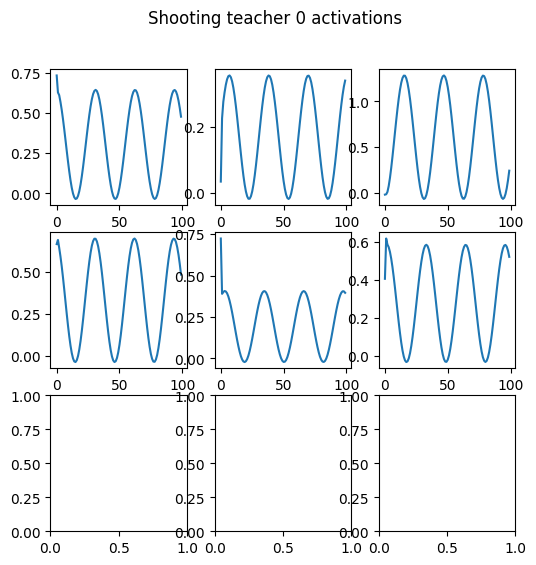

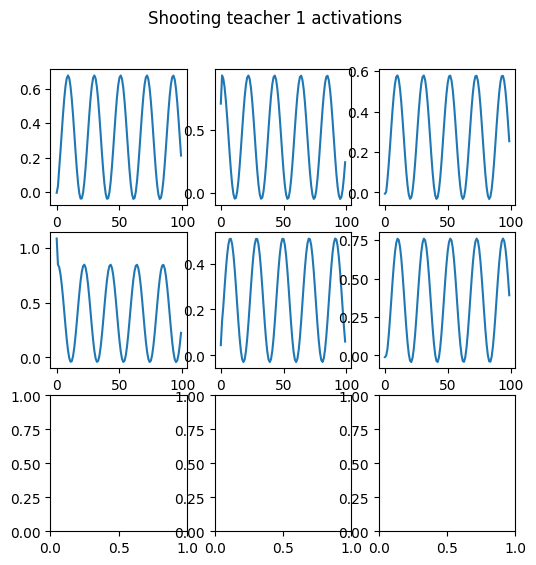

In [131]:
for k in range(K):
    fig, axes = plt.subplots(int(jnp.ceil(jnp.sqrt(D))), int(jnp.ceil(jnp.sqrt(D))), figsize=(6, 6))
    for i in range(D):
        ax = axes[i // int(jnp.ceil(jnp.sqrt(D))), i%int(jnp.ceil(jnp.sqrt(D)))]
        ax.plot(shooting_teacher_auxs[k]['x'][:, i])
    fig.suptitle(f'Shooting teacher {k} activations')

## Train students

In [132]:
x_init[0]

Array([[0.78097904, 0.184731  , 0.7742541 , 0.03460705, 0.70586205,
        0.05251098],
       [0.61368704, 0.7828101 , 0.00416386, 0.52134156, 0.39966083,
        0.21323228]], dtype=float32)

In [133]:
jnp.reshape(x_init, (100,12))[0,:]

Array([0.78097904, 0.184731  , 0.7742541 , 0.03460705, 0.70586205,
       0.05251098, 0.61368704, 0.7828101 , 0.00416386, 0.52134156,
       0.39966083, 0.21323228], dtype=float32)

In [134]:
key = jax.random.PRNGKey(42)
K = len(angular_freqs)
D=6
collocation_student = model.CollocationModel(K= K, D = D, T=T, key =key, x = jnp.reshape(x_init, (T, -1)), lambdas = model.LAMBDAS)
optimizer = optax.adam(1e-3)
optimizer_state = optimizer.init(collocation_student)
for _ in tqdm.trange(int(1e5)):
    key, subkey = jax.random.split(key)
    collocation_student, optimizer_state, collocation_student_aux = model.train_step(collocation_student, optimizer_state, optimizer, teacher_y, key=subkey)
    if _ % 2e4 == 0:
        pprint.pprint(collocation_aux['losses'])

  0%|          | 0/100000 [00:00<?, ?it/s]

{'activation_energy': Array(0.17875557, dtype=float32),
 'activation_positivity': Array(0.00010807, dtype=float32),
 'readout_energy': Array(0.19725327, dtype=float32),
 'target': Array(3.4393625e-07, dtype=float32),
 'transition': Array(1.5324204e-06, dtype=float32),
 'transition_energy': Array(0.07068176, dtype=float32)}
{'activation_energy': Array(0.17875557, dtype=float32),
 'activation_positivity': Array(0.00010807, dtype=float32),
 'readout_energy': Array(0.19725327, dtype=float32),
 'target': Array(3.4393625e-07, dtype=float32),
 'transition': Array(1.5324204e-06, dtype=float32),
 'transition_energy': Array(0.07068176, dtype=float32)}
{'activation_energy': Array(0.17875557, dtype=float32),
 'activation_positivity': Array(0.00010807, dtype=float32),
 'readout_energy': Array(0.19725327, dtype=float32),
 'target': Array(3.4393625e-07, dtype=float32),
 'transition': Array(1.5324204e-06, dtype=float32),
 'transition_energy': Array(0.07068176, dtype=float32)}
{'activation_energy': Arr

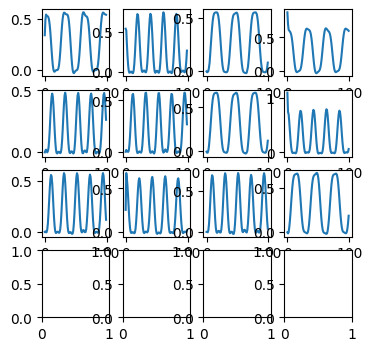

In [135]:
fig, axes = plt.subplots(int(jnp.ceil(jnp.sqrt(K*D))), int(jnp.ceil(jnp.sqrt(K*D))), figsize=(4, 4))
for i in range(K*D):
    ax = axes[i // int(jnp.ceil(jnp.sqrt(K*D))), i%int(jnp.ceil(jnp.sqrt(K*D)))]
    ax.plot(collocation_student.x[:,i])


In [136]:
## Again, make it better with shooting

shooting_student = model.ShootingModel(
    K=K,
    D=D,
    T=T,
    key=key,
    lambdas=model.SHOOTING_LAMBDAS,
    x0=collocation_student.x[0, :],
    W=collocation_student_aux['W'][:-1, :],
    R=collocation_student_aux['R'][:-1, :],
    bw=collocation_student_aux['W'][-1, :],
    br=collocation_student_aux['R'][-1, :])
optimizer = optax.adam(1e-3)
optimizer_state = optimizer.init(shooting_student)
for _ in tqdm.trange(int(2e4)):
    key, subkey = jax.random.split(key)
    shooting_student, optimizer_state, shooting_student_aux = model.train_step(shooting_student, optimizer_state, optimizer, teacher_y, key=subkey)
    if _ % 5e3 == 0:
        pprint.pprint(shooting_student_aux['losses'])

  0%|          | 0/20000 [00:00<?, ?it/s]

{'activation_energy': Array(0.12269104, dtype=float32),
 'activation_positivity': Array(4.0704526e-05, dtype=float32),
 'readout_energy': Array(0.13840434, dtype=float32),
 'target': Array(2.3463834e-05, dtype=float32),
 'transition_energy': Array(0.04962268, dtype=float32)}
{'activation_energy': Array(0.12757106, dtype=float32),
 'activation_positivity': Array(4.2734962e-05, dtype=float32),
 'readout_energy': Array(0.13351163, dtype=float32),
 'target': Array(3.3648166e-06, dtype=float32),
 'transition_energy': Array(0.04938867, dtype=float32)}
{'activation_energy': Array(0.12876906, dtype=float32),
 'activation_positivity': Array(4.2160456e-05, dtype=float32),
 'readout_energy': Array(0.13273892, dtype=float32),
 'target': Array(9.416985e-06, dtype=float32),
 'transition_energy': Array(0.04907771, dtype=float32)}
{'activation_energy': Array(0.12911585, dtype=float32),
 'activation_positivity': Array(4.0220537e-05, dtype=float32),
 'readout_energy': Array(0.13266627, dtype=float32),
 

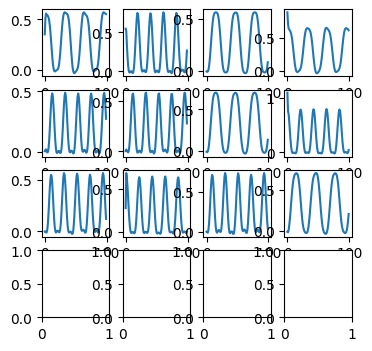

In [137]:
fig, axes = plt.subplots(int(jnp.ceil(jnp.sqrt(K*D))), int(jnp.ceil(jnp.sqrt(K*D))), figsize=(4, 4))
for i in range(K * D):
    ax = axes[i // int(jnp.ceil(jnp.sqrt(K * D))),
              i % int(jnp.ceil(jnp.sqrt(K * D)))]
    ax.plot(shooting_student_aux['x'][:, i])


## Now let's check the weights?!

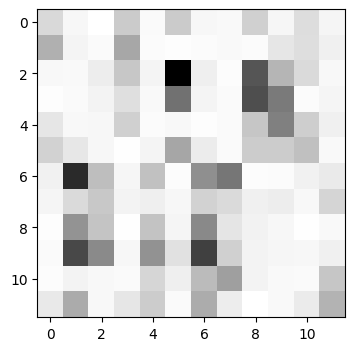

In [123]:
import numpy as np
fig = plt.figure(figsize=(4, 4))
index = jnp.array([0,3,5,8,9,10,1,2,4,6,7,11])
plt.imshow(np.abs(shooting_student_aux['W'][index,:]), cmap = 'Greys')

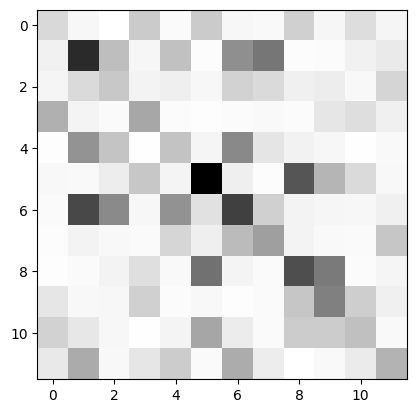

In [108]:
plt.imshow(abs(shooting_student_aux['W']), cmap = 'Greys')

In [111]:
shooting_student_aux['W'].shape

(12, 12)

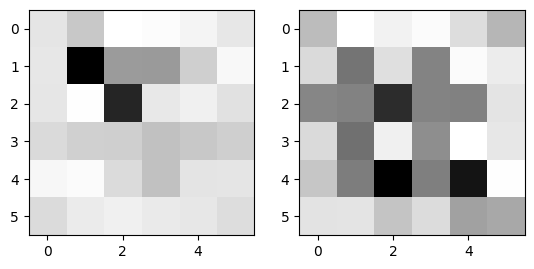

In [96]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(abs(shooting_teacher_auxs[0]['W']), cmap='Greys')
ax2.imshow(abs(shooting_teacher_auxs[1]['W']), cmap ='Greys' )


In [34]:
collocation_auxs[0]['W'].shape

(13, 12)